# Solving the maximum margin problem with quadratic programming (QP) and the RBF kernel

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data forming a well separated annulus.


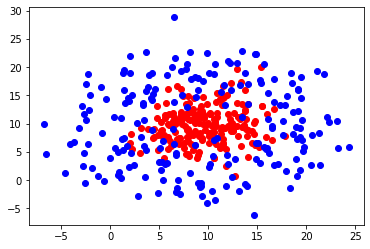

In [26]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 200

mu = np.array([10, 10])
sigma = np.array([[10, 0], [0, 10]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 3
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.show()


In [27]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((m_per_class, 1)), np.ones((m_per_class, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


In [29]:

# Kernels

def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
            
# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

m = X.shape[0]
rbf_sigma = 2
C = 1
c = - np.ones((m, 1))
Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
A = np.concatenate((-np.eye(m), np.eye(m)), 0)
b = np.concatenate((np.zeros((m, 1)), np.ones((m, 1)) * C), 0)
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -1.2813e+02 -4.0823e+02  1e+03  2e+01  3e+00
 1: -4.4911e+02 -8.8693e+02  9e+02  1e+01  2e+00
 2: -1.2929e+03 -1.8444e+03  8e+02  9e+00  1e+00
 3: -3.1367e+03 -3.9852e+03  1e+03  9e+00  1e+00
 4: -9.0342e+03 -1.0487e+04  2e+03  8e+00  1e+00
 5: -1.9296e+04 -2.1578e+04  3e+03  8e+00  1e+00
 6: -3.5794e+04 -3.9483e+04  4e+03  8e+00  1e+00
 7: -8.6276e+04 -9.4148e+04  8e+03  8e+00  1e+00
 8: -1.3218e+05 -1.4345e+05  1e+04  8e+00  1e+00
 9: -2.2720e+05 -2.4556e+05  2e+04  8e+00  1e+00
10: -3.6454e+05 -3.9482e+05  3e+04  8e+00  1e+00
11: -4.3754e+05 -4.7554e+05  4e+04  8e+00  1e+00
12: -6.9098e+05 -7.6221e+05  7e+04  8e+00  1e+00
13: -1.3456e+06 -1.5484e+06  2e+05  7e+00  1e+00
14: -2.6324e+06 -3.2280e+06  6e+05  6e+00  8e-01
15: -3.9198e+06 -4.7772e+06  9e+05  3e+00  4e-01
16: -4.2956e+06 -4.3895e+06  9e+04  5e-09  2e-10
17: -4.3173e+06 -4.3274e+06  1e+04  1e-09  2e-10
18: -4.3199e+06 -4.3203e+06  5e+02  3e-09  2e-10
19: -4.3200e+06 -4.32

In [30]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [1.42876563e-04 2.72916527e-05 5.71057747e+03 1.26985143e+03
 3.73927484e+03 2.86630647e-05 2.68699866e+03 6.63486147e+03
 1.77409564e+04 4.87071090e+02 1.02629918e-05 2.05127513e+04
 1.69713659e+04 7.99017389e+02 3.25174592e+03 1.01350626e-04
 1.47252686e-05 1.91933964e-05 5.28152690e+03 1.41311018e+03
 2.07303912e-05 3.78151178e-05 1.43347626e-05 1.87029297e-04
 1.18194113e-05 1.59398901e+04 1.91711715e+01 2.02694688e-05
 1.34853259e-05 3.54702669e+03 2.97999070e-05 9.99112629e+03
 1.25752927e-05 3.87616018e-05 1.40466587e-05 5.70091566e+02
 1.21676971e-05 4.64834679e+03 1.98647277e-05 1.94419714e+04
 1.85831531e+03 5.29765465e+03 2.44583668e+04 1.74429242e+04
 4.13177961e+04 1.51006102e-05 3.40556656e+04 9.32992383e-05
 3.93611003e-05 3.81771287e-05 1.49423371e-05 1.94125656e-05
 1.05842785e-04 4.02653978e+03 1.89874277e+03 2.60745652e+04
 5.62692012e+04 1.28546710e+05 2.92678851e+06 3.77237667e+04
 1.30094573e-05 1.09826753e-05 6.31233755e+05 1.09994995e+0

array([-3.6340607e-06])

In [31]:
# How to perform inference with a kernel rather than w,b?

def b_from_alpha(X, y, alpha, rbf_sigma):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
    return b

def rbf_kernel_1(x, xprime, rbf_sigma):
    return np.exp(- (x - xprime) @ (x - xprime) / 2 / rbf_sigma / rbf_sigma)
    
def svm_predict(x, X, y, alpha, rbf_sigma):
    b = b_from_alpha(X, y, alpha, rbf_sigma)
    results = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        results[i] = 0
        for j in range(X.shape[0]):
            results[i, 0] += alpha[j] * y[j, 0] * rbf_kernel_1(x[i,:], X[j,:], rbf_sigma)
        results[i] += b
    return np.sign(results)

# svm_predict(np.array([[10, 10], [20, 20]]), X, y, opt_params, rbf_sigma)

In [34]:
train_pred = svm_predict(X, X, y, opt_params, rbf_sigma)
accuracy = (train_pred == y).mean()
print('Training accuracy:', accuracy)

Training accuracy: 0.89


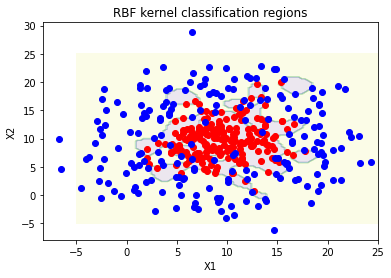

In [32]:

# Blue margin line

# x21 = (-w[0] * x11 - b + 1) / w[1]
# x22 = (-w[0] * x12 - b + 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

# Red margin line

# x21 = (-w[0] * x11 - b - 1) / w[1]
# x22 = (-w[0] * x12 - b - 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

# Overlay colored regions according to svm_predict

grid_x, grid_y = np.mgrid[-5:25:100j, -5:25:100j]
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
grid_z = svm_predict(grid_xy, X, y, opt_params, rbf_sigma).reshape((100, 100))

plt.contourf(grid_x, grid_y, grid_z, alpha=0.1)

plt.title('RBF kernel classification regions')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()